# **Анализ сети залов Третьяковской галереи**

Николаев Дмитрий, Пономарева Анна

Мы решили исследовать с помощью анализа сетевых структур схему Третьяковской галереи в Москве.

Это может быть важно с практической точки зрения для понимания, **какие залы могут быть закрыты на ремонт одновременно**, без ограничения доступа в другие работающие залы.

Это также может помочь работникам галлереи **организовывать выставки**, располагая известные, значимые картины (или картины, которые хотят популяризировать) в наиболее проходных/посещаемых залах, мимо которых посетители галереи точно не пройдут.

<img src="https://ibb.org.ru/images/2024/10/22/TRETYKOVSKAY-GALEREY-SKEMA.jpg" alt="Третьяковская галерея схема" border="0">

 Источник: сайт Мос.культура *https://moskultura.ru/museums/tretyakovskaya-galereya.*

Данные были взяты из карты Третьяковской галереи и были перенесены вручную в Эксель в формате ребер (source-target).

Описание данных: вершинами графа являются номера залов в Третьяковской галерее. Вершины соединены ребрами в том случае, если между залами есть проход. Так как в галерее 2 этажа, то считали залы первого этажа, примыкающие к лестнице, соединенными с залами 2 этажа. Граф является неориентированным, так как проход работает в обе стороны. Граф не является взвешенным, потому что за проход мы считали дверной проем, который везде одинаковый.

В графе 62 вершины-зала и 77 ребра-прохода.

In [ ]:
!pip install pyvis
!pip install python-louvain
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import matplotlib.cm as cm
import matplotlib.colors as colors
import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00


In [ ]:
data = pd.read_excel('https://docs.google.com/spreadsheets/d/e/2PACX-1vRGWSHA7bQIoGIdehwDp97qNcdaBkeLsu40pVJ4-8xxR8122oLOKkQCkHASoUkrdVwhbbgjCKnyxrUx/pub?output=xlsx')
data

,Source,Target
0,1,2
1,1,3
2,1,7
3,2,25
4,4,5
...,...,...
72,58,59
73,59,60
74,59,62
75,60,61


In [ ]:
G = nx.Graph() #создаем граф
#добавляем вершины
for i in range(1, 63):
  G.add_node(i)
#добавляем ребра
for i in range(77):
  G.add_edge(data.iloc[i, 0], data.iloc[i, 1])
G.to_undirected()

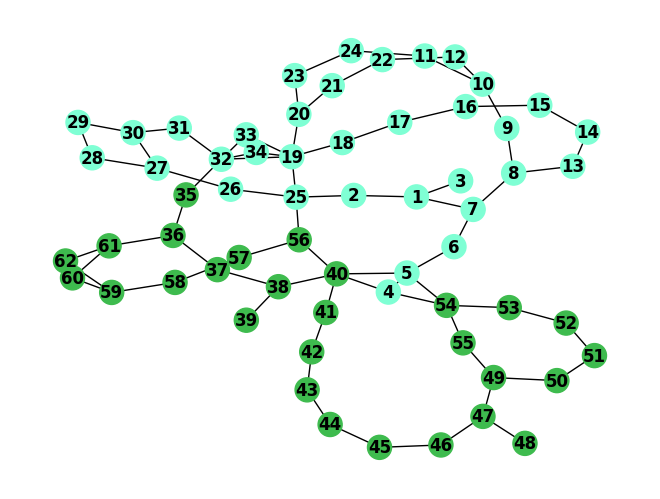

In [ ]:
# покрасим граф по этажам
color_map = []
for node in G:
    if node < 35:
        color_map.append('#7FFFD4') #этаж 1
    else:
        color_map.append('#3EBB4E') #этаж 2

pos = nx.kamada_kawai_layout(G) ## алгоритм для расстояния между вершинами на картинке
nx.draw(G, pos, font_weight='bold', node_color=color_map, with_labels=True)

In [ ]:
df = pd.DataFrame(data)

G1 = nx.from_pandas_edgelist(df,
                            source = 'Source',
                            target = 'Target',
                            create_using= nx.DiGraph)


In [ ]:
# Инициализация сети PyVis
g = Network(height='750px', width='100%', notebook=True, cdn_resources='remote')

# Добавление узлов
for node in G1.nodes():
    g.add_node(
        node,
        title=f"Узел {node}"
    )
# Добавление рёбер
for source, target in G1.edges():
    g.add_edge(source, target)

# Отображение графа
display(HTML(g.generate_html()))

In [ ]:
deg_cent = nx.degree_centrality(G) ## находим степенную центральность
deg_cent_df = pd.DataFrame.from_dict(deg_cent, orient='index', columns=['deg_cent']) ## переводим данные в датафрейм
deg_cent_df.sort_values(by='deg_cent', ascending=False) ## производим сортировку

,deg_cent
19,0.098361
32,0.081967
40,0.081967
5,0.065574
54,0.065574
...,...
12,0.032787
37,0.032787
48,0.016393
3,0.016393


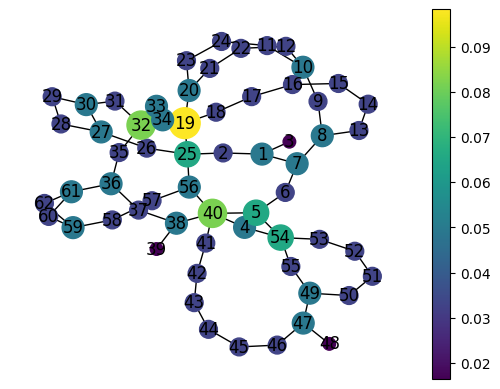

In [ ]:
# Граф по степенной центральности
deg_centrality = np.fromiter(deg_cent.values(), float)

sizes = deg_centrality / np.max(deg_centrality) * 200
normalize = colors.Normalize(vmin=deg_centrality.min(), vmax=deg_centrality.max())
colormap = cm.viridis
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(deg_centrality)
plt.colorbar(scalarmappaple, ax=plt.gca()) ## делаем палитру цветов

pos = nx.kamada_kawai_layout(G) ## алгоритм для расстояния между вершинами на картинке
nx.draw(G, pos, node_color=deg_centrality, font_weight='bold', node_size=deg_centrality*5e3) ## ранжирование по степенной центральности
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
# Интерактивный граф по степенной центральности
centrality = nx.degree_centrality(G1)

# Выбор цветовой карты из matplotlib
cmap = cm.get_cmap('cividis')
# Функция для преобразования центральности в цвет
def get_node_color(centrality_value, cmap):
    # Преобразуем значение центральности в RGBA
    rgba = cmap(centrality_value * 15)
    # Преобразуем RGBA в HEX
    return colors.to_hex(rgba)

# Создание словаря с цветами для узлов
node_colors = {node: get_node_color(cent, cmap) for node, cent in centrality.items()}

# Инициализация сети PyVis
g = Network(height='750px', width='100%', notebook=True, cdn_resources='remote')

# Добавление узлов с цветами и заголовками
for node in G1.nodes():
    g.add_node(
        node,
        title=f"Узел {node}<br>Центральность: {centrality[node]:.3f}",
        color=node_colors[node],
        size=15 + 500 * centrality[node]  # Размер узла пропорционален центральности
    )

# Добавление рёбер
for source, target in G1.edges():
    g.add_edge(source, target)

# Отображение графа
display(HTML(g.generate_html()))

<ipython-input-9-c59b2debab05>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cividis')


Степенная центральность показывает, что залом, который соединен с наибольшим количеством других залов является 19 (самый важный), а также  40, 32, 5. Можно заметить, что эти залы соединены с большим количеством других заллов на своем этаже, и, кроме того, расположены близко к лестницам, т.е. соединены с залами других этажей.

In [ ]:
close_cent = nx.closeness_centrality(G) ## находим центральность по близости
close_cent_df = pd.DataFrame.from_dict(close_cent, orient='index', columns=['close_cent']) ## переводим данные в датафрейм
close_cent_df.sort_values(by='close_cent', ascending=False) ## производим сортировку

,close_cent
25,0.253112
56,0.248980
40,0.247967
19,0.238281
5,0.233716
...,...
50,0.137698
51,0.135857
45,0.129237
46,0.125514


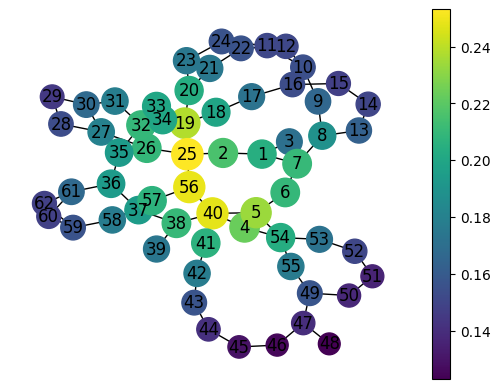

In [ ]:
# Граф по центральности по близости
close_centrality = np.fromiter(close_cent.values(), float)

sizes = close_centrality / np.max(close_centrality) * 200
normalize = colors.Normalize(vmin=close_centrality.min(), vmax=close_centrality.max())
colormap = cm.viridis
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(close_centrality)
plt.colorbar(scalarmappaple, ax=plt.gca()) ## делаем палитру цветов

pos = nx.kamada_kawai_layout(G) ## алгоритм для расстояния между вершинами на картинке
nx.draw(G, pos, node_color=close_centrality, font_weight='bold', node_size=close_centrality*2e3) ## ранжирование по центральности по близости
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
# Интерактивный граф по центральности по близости
centrality = nx.closeness_centrality(G1)

# Выбор цветовой карты из matplotlib
cmap = cm.get_cmap('cividis')

# Функция для преобразования центральности в цвет
def get_node_color(centrality_value, cmap):
    # Преобразуем значение центральности в RGBA
    rgba = cmap(centrality_value * 10)
    # Преобразуем RGBA в HEX
    return colors.to_hex(rgba)

# Создание словаря с цветами для узлов
node_colors = {node: get_node_color(cent, cmap) for node, cent in centrality.items()}

# Инициализация сети PyVis
g = Network(height='750px', width='100%', notebook=True, cdn_resources='remote')

# Добавление узлов с цветами и заголовками
for node in G1.nodes():
    g.add_node(
        node,
        title=f"Узел {node}<br>Центральность: {centrality[node]:.3f}",
        color=node_colors[node],
        size=15 + 300 * centrality[node]  # Размер узла пропорционален центральности
    )

# Добавление рёбер
for source, target in G1.edges():
    g.add_edge(source, target)

# Отображение графа
display(HTML(g.generate_html()))

<ipython-input-12-409b5093bfcf>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cividis')


Центральность по близости изходит из идеи о том что, наиболее важной является вершина, находящаяся ближе всех к
другим вершинам сети.
Лучшей по этому параметру оказались залы 25, 40 и 56 из-за того, что они находится на лестнице и связывает два этажа, а также связаны вершинами, через которые соединяют разные блоки этажей, поэтому эти залы в среднем ближе к остальным.
Далее по этому индексу идет 19 зал, который находится около лестницы и соединяет два блока, поэтому также находится в топе по данному показателю.

Центральность по близости на практике может быть использована для назначения встречи двух заблудившихся на разных концах галереи знакомых, если они плохо представляют, где находятся. Так до зала с наибольшей центральностью по близости им (в среднем) каждому близко дойти.

Еще одно возможное применение: расположить в зале с наибольшей центральностью по близости сотрудника, которому по той или иной причине может срочно понадобиться добраться в конкретный зал для устранения проблемы (охрана картин, например)

In [ ]:
betw_cent = nx.current_flow_betweenness_centrality(G) ## находим центральность по посредничеству
betw_cent_df = pd.DataFrame.from_dict(betw_cent, orient='index', columns=['betw_cent']) ## переводим данные в датафрейм
betw_cent_df.sort_values(by='betw_cent', ascending=False) ## производим сортировку

,betw_cent
40,0.411790
19,0.379212
25,0.330063
56,0.284840
5,0.282662
...,...
28,0.031233
29,0.030985
39,0.000000
3,0.000000


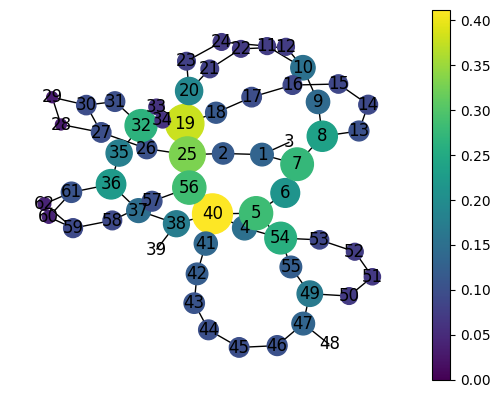

In [ ]:
# Граф по центральности по посредничеству
betw_centrality = np.fromiter(betw_cent.values(), float)

sizes = betw_centrality / np.max(betw_centrality) * 200
normalize = colors.Normalize(vmin=betw_centrality.min(), vmax=betw_centrality.max())
colormap = cm.viridis
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(betw_centrality)
plt.colorbar(scalarmappaple, ax=plt.gca()) ## делаем палитру цветов

pos = nx.kamada_kawai_layout(G) ## алгоритм для расстояния между вершинами на картинке
nx.draw(G, pos, node_color=betw_centrality, font_weight='bold', node_size=betw_centrality*2e3) ## ранжирование по центральности по посредничеству
nx.draw_networkx_labels(G, pos)
plt.show()


In [ ]:
# Интерактивный граф по центральности по посредничеству
centrality = nx.current_flow_betweenness_centrality(G1.to_undirected())

# Выбор цветовой карты из matplotlib
cmap = cm.get_cmap('cividis')
# Функция для преобразования центральности в цвет
def get_node_color(centrality_value, cmap):
    # Преобразуем значение центральности в RGBA
    rgba = cmap(centrality_value * 4)
    # Преобразуем RGBA в HEX
    return colors.to_hex(rgba)

# Создание словаря с цветами для узлов
node_colors = {node: get_node_color(cent, cmap) for node, cent in centrality.items()}

# Инициализация сети PyVis
g = Network(height='750px', width='100%', notebook=True, cdn_resources='remote')

# Добавление узлов с цветами и заголовками
for node in G1.nodes():
    g.add_node(
        node,
        title=f"Узел {node}<br>Центральность: {centrality[node]:.3f}",
        color=node_colors[node],
        size=15 + 175 * centrality[node]  # Размер узла пропорционален центральности
    )

# Добавление рёбер
for source, target in G1.edges():
    g.add_edge(source, target)

# Отображение графа
display(HTML(g.generate_html()))

<ipython-input-15-aeeb5828e802>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cividis')


Центральность по посредничеству показывает, через какие залы проходит наибольшее число кратчайших путей. Среди наиболее важных залов по этому показателю можно выделить 40 (самое высокое значение центральности по посредничеству), 19, 25 залы. Можно отметить, что через эти залы пролегают основные маршруты осмотра галереи. Только пройдя через них, посетители могут попасть в крупные тематические блоки галереи.

С практической точки зрения, если сотрудники Третьяковской галереи хотят, чтобы какую-то картину посетители увидели с большей вероятностью, следует ее поместить в один из залов с высокой центральностью по посредничеству, т.к. именно такие залы будут самыми проходными. Этот факт может служить просветительским целям, помогая популяризировать наиболее ценные картины. Кроме того, именно залы с высокой центральностью по посредничеству нежелательно закрывать на ремонт, потому что это существенно затруднит маршрут осмотра для посетителей выставки.

In [ ]:
page_rank = nx.pagerank(G) ## находим центральность по pagerank
page_rank_df = pd.DataFrame.from_dict(page_rank, orient='index', columns=['page_rank']) ## переводим данные в датафрейм
page_rank_df.sort_values(by='page_rank', ascending=False) ## производим сортировку

,page_rank
19,0.031378
40,0.028191
32,0.026101
54,0.023240
25,0.022722
...,...
35,0.012125
31,0.012112
48,0.008658
3,0.008178


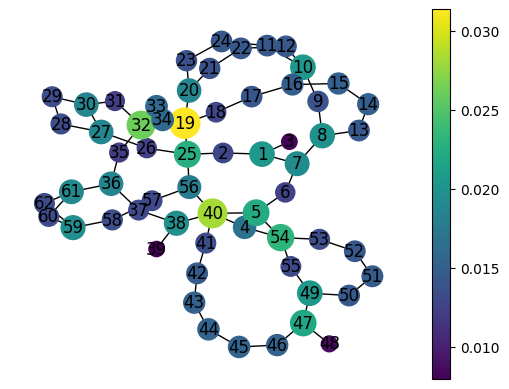

In [ ]:
# Граф для центральности по page rank
pagerank_centrality = np.fromiter(page_rank.values(), float)

sizes = pagerank_centrality / np.max(pagerank_centrality) * 200
normalize = colors.Normalize(vmin=pagerank_centrality.min(), vmax=pagerank_centrality.max())
colormap = cm.viridis
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(pagerank_centrality)
plt.colorbar(scalarmappaple, ax=plt.gca()) ## делаем палитру цветов

pos = nx.kamada_kawai_layout(G) ## алгоритм для расстояния между вершинами на картинке
nx.draw(G, pos, node_color=pagerank_centrality, font_weight='bold', node_size=pagerank_centrality*15e3) ## ранжирование по pagerank
nx.draw_networkx_labels(G, pos)
plt.show()


In [ ]:
# Интерактивный граф для центральности по page rank
centrality = nx.pagerank(G1)

# Выбор цветовой карты из matplotlib
cmap = cm.get_cmap('cividis')
# Функция для преобразования центральности в цвет
def get_node_color(centrality_value, cmap):
    # Преобразуем значение центральности в RGBA
    rgba = cmap(centrality_value * 40)
    # Преобразуем RGBA в HEX
    return colors.to_hex(rgba)

# Создание словаря с цветами для узлов
node_colors = {node: get_node_color(cent, cmap) for node, cent in centrality.items()}

# Инициализация сети PyVis
g = Network(height='750px', width='100%', notebook=True, cdn_resources='remote')

# Добавление узлов с цветами и заголовками
for node in G1.nodes():
    g.add_node(
        node,
        title=f"Узел {node}<br>Центральность: {centrality[node]:.3f}",
        color=node_colors[node],
        size=15 + 800 * centrality[node]  #Размер узла пропорционален центральности
    )

# Добавление рёбер
for source, target in G1.edges():
    g.add_edge(source, target)

# Отображение графа
display(HTML(g.generate_html()))

<ipython-input-18-16c946d5bc97>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cividis')


Ценральность pagerank показывает, сколько авторитетных вершин с высоким рангом ссылается на данную вершину.
Самое большое значение данной центральности имеет 19 зал, так как он соединяется с 25, 20 и 34 вершинами, которые сами являются "авторитетными"

In [ ]:
eig_cent = nx.eigenvector_centrality(G) ## находим центральность по собственому вектору
eig_cent_df = pd.DataFrame.from_dict(eig_cent, orient='index', columns=['eig_cent']) ## переводим данные в датафрейм
eig_cent_df.sort_values(by='eig_cent', ascending=False) ## производим сортировку

,eig_cent
19,0.521139
32,0.462375
34,0.395674
33,0.395674
25,0.215795
...,...
47,0.001083
44,0.000619
46,0.000394
48,0.000311


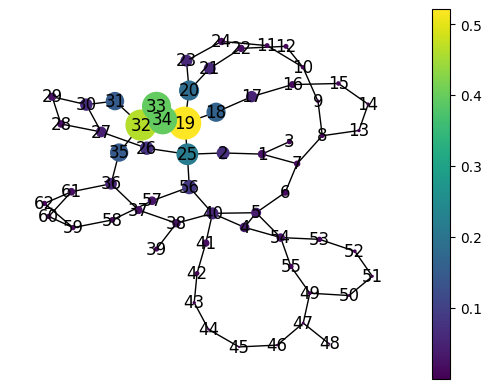

In [ ]:
# Граф для центральности по собственному вектору
eig_centrality = np.fromiter(eig_cent.values(), float)

sizes = eig_centrality / np.max(eig_centrality) * 200
normalize = colors.Normalize(vmin=eig_centrality.min(), vmax=eig_centrality.max())
colormap = cm.viridis
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(eig_centrality)
plt.colorbar(scalarmappaple, ax=plt.gca()) ## делаем палитру цветов

pos = nx.kamada_kawai_layout(G) ## алгоритм для расстояния между вершинами на картинке
nx.draw(G, pos, node_color=eig_centrality, font_weight='bold', node_size=eig_centrality*1e3) ## график по центральности по собственному вектору
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
# Интерактивный граф для центральности по собственному вектору
centrality = nx.eigenvector_centrality(G1.to_undirected())

# Выбор цветовой карты из matplotlib
cmap = cm.get_cmap('cividis')

# Функция для преобразования центральности в цвет
def get_node_color(centrality_value, cmap):
    # Преобразуем значение центральности в RGBA
    rgba = cmap(centrality_value * 15)
    # Преобразуем RGBA в HEX
    return colors.to_hex(rgba)

# Создание словаря с цветами для узлов
node_colors = {node: get_node_color(cent, cmap) for node, cent in centrality.items()}

# Инициализация сети PyVis
g = Network(height='750px', width='100%', notebook=True, cdn_resources='remote')

# Добавление узлов с цветами и заголовками
for node in G1.nodes():
    g.add_node(
        node,
        title=f"Узел {node}<br>Центральность: {centrality[node]:.3f}",
        color=node_colors[node],
        size=15 + 80 * centrality[node]  # Размер узла пропорционален центральности
    )

# Добавление рёбер
for source, target in G1.edges():
    g.add_edge(source, target)

# Отображение графа
display(HTML(g.generate_html()))

<ipython-input-21-155b74053bd5>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('cividis')


Центральность по собственному вектору основана на идее о том, что важность вершины зависит от важности ее соседей. Лучшими по этому критерию являются 19, 34, 32, 33 залы, так как они все связаны между собой и с первым этажом галереи. Центральность по собственному вектору (в отличие от других центральностей) выше для залов 34, 32, 33 из-за их "важного соседа" - зала 19.

In [ ]:
# Добавление всех центральностей в общую таблицу
all_cent = deg_cent_df.join(close_cent_df).join(betw_cent_df).join(page_rank_df).join(eig_cent_df) ## все центральности вместе
all_cent.head(60)

,deg_cent,close_cent,betw_cent,page_rank,eig_cent
1,0.049180,0.204698,0.131426,0.020323,0.025791
2,0.032787,0.215548,0.116665,0.013007,0.069309
3,0.016393,0.170391,0.000000,0.008178,0.007399
4,0.049180,0.223443,0.149849,0.016885,0.035670
5,0.065574,0.233716,0.282662,0.022281,0.039009
6,0.032787,0.209622,0.213440,0.012579,0.014978
7,0.049180,0.210345,0.273788,0.019149,0.013187
8,0.049180,0.188272,0.235487,0.019850,0.005192
9,0.032787,0.165761,0.140516,0.013850,0.002809
10,0.049180,0.154822,0.153436,0.020488,0.004599


In [ ]:
# Поиск модулярности
from networkx.algorithms import community
#part = community.best_partition(G)
mod = community.greedy_modularity_communities(G) ##разбиение по группам
for i in range(len(mod)):
  print(f'{i + 1} группа: {list(mod[i])}')

1 группа: [41, 42, 43, 44, 45, 46, 47, 48, 49, 55]
2 группа: [35, 36, 37, 38, 39, 59, 60, 61, 62]
3 группа: [10, 11, 12, 20, 21, 22, 23, 24]
4 группа: [4, 5, 40, 50, 51, 52, 53, 54]
5 группа: [1, 2, 3, 6, 7, 8, 9]
6 группа: [16, 17, 18, 13, 14, 15]
7 группа: [26, 27, 28, 29, 30, 31]
8 группа: [32, 33, 34, 19]
9 группа: [56, 25, 58, 57]


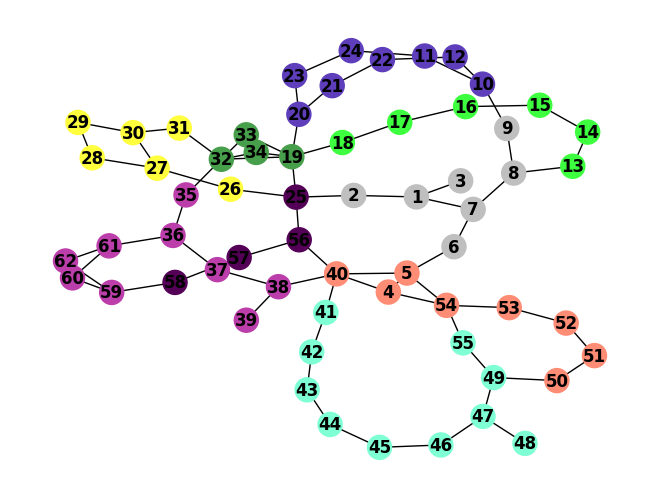

In [ ]:
color_map = []
## раскраска по группам
for node in G:
    if node in mod[0]:
        color_map.append('#7FFFD4')

    elif node in mod[1]:
        color_map.append('#BB3EAB')

    elif node in mod[2]:
        color_map.append('#5E3EBB')

    elif node in mod[3]:
        color_map.append('#FF8C75')

    elif node in mod[4]:
        color_map.append('#BFBFBF')

    elif node in mod[5]:
        color_map.append('#3DFF3F')

    elif node in mod[6]:
        color_map.append('#FFFF3D')

    elif node in mod[7]:
        color_map.append('#479E4B')

    elif node in mod[8]:
        color_map.append('#540057')


pos = nx.kamada_kawai_layout(G) ## алгоритм для расстояния между вершинами на картинке
nx.draw(G, pos, font_weight='bold', node_color=color_map, with_labels=True)

С помощью модулярности мы выделили следующие группы залов-вершин:

1 группа: [41, 42, 43, 44, 45, 46, 47, 48, 49, 55]

2 группа: [35, 36, 37, 38, 39, 59, 60, 61, 62]

3 группа: [10, 11, 12, 20, 21, 22, 23, 24]

4 группа: [4, 5, 40, 50, 51, 52, 53, 54]

5 группа: [1, 2, 3, 6, 7, 8, 9]

6 группа: [16, 17, 18, 13, 14, 15]

7 группа: [26, 27, 28, 29, 30, 31]

8 группа: [32, 33, 34, 19]

9 группа: [56, 25, 58, 57]

<img src="https://ibb.org.ru/images/2024/10/22/TRETYKOVSKAY-GALEREY-SKEMA.jpg" alt="Третьяковская галерея схема" border="0">

Интересно, что группы, выделенные с помощью модулярности отчасти совпадают с делением экспозиции музея на тематические блоки.

Однако, выделенные нами группы включают группу 4 и группу 9, в которые попали залы с разных этажей. Для организации выставки такое решение сложно считать оптимальным, так как лестница является естественным разделителем блоков выставки.

При этом, можно сказать, что блок "Живопись и скульптура **второй** половины XIX века" и блок "Живопись и скульптура **первой** половины XIX века" выделены неоптимально на плане Третьяковской галереи. Дело в том, что залы 10-12 и 20-24 образуют на схеме тесно связанный блок в центре второго этажа. Это подтверждает модулярность (группа 3, выделенная по этому принципу). Поэтому можно считать, что расположение экспозиции не оптимально, и имеет смысл переместить экспозицию "Живопись и скульптура **первой** половины XIX века" в блок 10-12 и 20-24 залов, а в залы 8-9, 13-15 переместить экспозицию "Живопись и скульптура **второй** половины XIX века". Частично реорганизовав эти 2 смысловых блока, можно сделать экспозицию более логичной, интуитивной для посетителя. Это упростит маршрут просмотра и поможет гостям Третьяковской галереи "не потеряться, не блуждать" между первой и второй половиной XIX века.



# Выводы и рекомендации:

Мы посетили Третьяковскую галерею и прошлись по всем залам, чтобы проверить, насколько экпозиция сотвествует нашему анализу по показателям важности залов.
В 41 зале, который имеет большие показатели центральности, находятся известные картины "Девочка с персиками" Серова, и этот зал недалеко от лестницы, поэтому решение музея расположить картины таким образом верное.

<img src="https://ibb.org.ru/images/2024/10/22/DEVOCKA-S-PERSIKAMI.jpg" alt="Девочка с персиками" border="0" alt="drawing" width="500"/>

Также знаковая, известная картина Шишкина "Утро в сосновом лесу" висит в зале 25 с высокими показателями центральности, недалеко от лестницы. Мы считаем это решение галереи тоже верным.

<img src="https://ibb.org.ru/images/2024/10/22/UTRO-V-SOSNOVOM-LESU.jpg" alt="Утро в сосновом лесу" border="0" alt="drawing" width="500"/>

 Однако, 39 и 37 залы имеют низкие показатели центральности, хотя в них находятся известные и знаковые картины, такие как "Март" и "Весна. Большая вода" Левитана, "Видение отроку Варфоломею" Нестерова. Значит, имеет перевесить данные картины в другие залы с большей центральностью.

 <img src="https://ibb.org.ru/images/2024/10/22/MART.jpg" alt="Март" border="0" alt="drawing" width="500"/>

 <img src="https://ibb.org.ru/images/2024/10/22/VESNA.-BOLSAY-VODA.jpg" alt="Весна. Большая вода" border="0" alt="drawing" width="500"/>

 <img src="https://ibb.org.ru/images/2024/10/22/NESTEROV.jpg" alt="Нестеров" border="0" alt="drawing" width="500"/>

Также мы заметили, что в залах 27 и 28 (с относительно низкими показателями центральности) находятся значимые работы  Василия Верещагина ("Апофеоз войны", "Побеждённые (Панихида)") и Василия Сурикова ("Боярыня Морозова", "Утро стрелецкой казни"). Так как у этих залов низкая центральность, посетители галереи могут пройти мимо них и не увидеть шедевры русской живописи. Поэтому можно рекомендовать перевесить эти картины.

<img src="https://ibb.org.ru/images/2024/10/22/BOYRYNY-MOROZOVA.jpg" alt="Боярыня Морозова" border="0" alt="drawing" width="500"/>
<img src="https://ibb.org.ru/images/2024/10/22/UTRO-STRELETKOI-KAZNI.jpg" alt="Утро стрелецкой казни" border="0" alt="drawing" width="500"/>

 Также, по нашим расчетам, оптимальнее было бы расположить залы 56-62 с Древнерусским искусством в другой блок, который находится подальше от лестницы, так как он вызывает меньший интерес у посетителей, при этом через него проходят многие маршруты.

# Общий вывод по работе

Сетевой анализ позволил нам проанализировать и математизировать подходы к оптимальному размещению произведений русской художественной культуры. Для нашей цели наиболее релевантными оказались центральность по посредничеству и модулярность, однако остальные показатели также были использованы нами для выявления более широкого спектра характеристик залов.
Сетевой анализ имеет широкое практическое примененеие и помогает не только исследовать текущее состояние, но и выдвигать рекомендации и предложения.